# Filtering, Pathway analysis, and Plots for Inter-Embryo variability

### *Given the dataframes (mpKLD and null model) from the Inter-Embryo_Divergence_Analysis.ipynb notebook, this notebook conducts pathway analysis and creates plots found in figure 2 and in the supplementary information.*

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


from scipy.special import rel_entr, kl_div
from scipy.special import softmax
from scipy.stats import entropy
from scipy import stats


from functools import reduce

In [3]:
import statsmodels.api as sm
import math
import re

In [56]:
import json
import requests

# 1. We calculate the information and perform the processing necessary to filter the mpKLD dataframe

## 1.1 Prepare the adata object and mpKLD dataframe to be consistent with further analysis

### We prepare the adata object:
* Choose a single timepoint for the analysis
* Add a timepoint column that converts somites to hours post fertilization (HPF)
* If we want to compute the analysis for the entire embryo, we call the function 'make_columns' with the annotation 'cell_type_1'. Otherwise, we call the function with the desired cell clusters, and the column in which the cell cluster labels can be found
* If the timepoint column in the mpKLD dataframe has 'hpf' on the end, 'make_timepointHPF_kldf' will remove it and create the timepointHPF column, leaving just the integer so it matches the adata object timepointHPF column

In [4]:
# function: subsets adata for a timepoint
# arguments: adata object and desired timepoint
# output: subset adata object
    
def myadata(adata, timepoint):
    myadata = adata[adata.obs.timepoint == timepoint].copy()
    
    return myadata
    

In [5]:
#function: turn somites into HPF for 'timepointHPF' column
#arguments: adata for a specific timepoint, the timepoint, and list of cell types 
#output: dataframe with gene_mean, fraction_0s columns for each gene/celltype/timepoint

def convertHPF(row):  
    
    if row['timepoint'] == '0 budstage':
        return 10
    elif row['timepoint'] == '05somite':
        return 12
    elif row['timepoint'] == '10somite':
        return 14  
    elif row['timepoint'] == '15somite':
        return 16
    elif row['timepoint'] == '20somite':
        return 19
    elif row['timepoint'] == '30somite':
        return 24
    
    

In [17]:
#function: adds a column to adata object with timepoint in hours post fertilization
#input: adata object
#output: after it is run on the adata object, it now has a column called 'timepoinHPF'

def make_timepointHPF(adata):
    
    adata.obs['timepointHPF'] = adata.obs.apply(lambda row: convertHPF(row), axis=1)

Makes the column with the cell type. Can run either for the whole embryo, as 'cell_type_1', or for a list of specific cell types.

In [6]:
#function: some preprocessing, go from adata object to input for general gene metrics
#input: adata object, and either a list of cell types with the cell type column name, or 'cell_type_1' if whole embryo
#output: adata object with Cells_Annotations column for cell type

def make_columns(adata, annotations = ['cell_type_1'], celltypecolumn = 'ontology_class'):
    
    if annotations[0] == 'cell_type_1':
        newadata = adata.copy()
        newadata.obs['Cells_Annotations'] = 'cell_type_1'
        
    else:
        newadata = adata[adata.obs[celltypecolumn].isin(annotations)].copy()
        newadata.obs['Cells_Annotations'] = newadata.obs[celltypecolumn].copy()
        
    
    return newadata


In [173]:
#function: makes columns for KLDF
#input: KL dataframe
#output: KL dataframe with timepointHPF (hours post fertilization) column, and renames KL columns with an added_kl

def make_timepointHPF_kldf(kldf = pd.DataFrame):
    
    kldf_new = kldf.rename(columns={"amax": "kl_amax", "amin": "kl_amin", "median": "kl_median", "std":"kl_std", "mean":"kl_mean"}).copy()

    kldf_new['timepointHPF'] = kldf_new['timepoint'].str.extract(r'(\d+)').astype(int)
    
    return kldf_new.drop(columns=['Unnamed: 0'])

## *Example code:*
* Upload adata object
* Make timepoint column and subset adata object for desired timepoint (function is 'my_adata')
* Make cell cluster column for desired cell clusters from the cell type column, or run for 'cell_type_1' if doing analysis on the whole embryo (functions 'make_timepointHPF' and 'make_columns')
* Now we have our example_adata, ready to run the inter-individual analysis   
* We upload the mpKLD dataframe from the notebook **Inter-Embryo_Divergence_Analysis**, and then run 'make_timepointHPF_kldf' to make sure the mpKLD dataframe has a matching timepointHPF column to the adata, and has specified the KL metrics vs. the gene metrics

In [38]:
adata = sc.read_h5ad('/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/early_timepoints/danio_atlas_umapv2_annotated.h5ad')

In [39]:
example_adata = myadata(adata, '05somite')

In [41]:
make_timepointHPF(example_adata)
example_adata = make_columns(example_adata, ['neural_anterior'], 'annotation_umapv2_global')

In [42]:
example_adata.obs

,orig.ident,X10X_run,fish,fish_n,timepoint,seqrun,cell_annotation,global_annotation,integrated_snn_res.0.5,seurat_clusters,...,leiden_v6_r0.32,leiden_v7_r0.3,leiden_v8_r0.31,leiden_v9_r0.31,leiden_v10_r0.25,leiden_v11_r0.22,leiden_v12_r0.23,annotation_umapv2_global,timepointHPF,Cells_Annotations
TDR35_AACCACACACCTGCAG-1,TDR35,TDR35,TDR35,35,05somite,1,Telencaphalon_Emx3,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_AAGGTAATCAGACAAA-1,TDR35,TDR35,TDR35,35,05somite,1,Telencaphalon_Emx3,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_ACATCGACAACGATTC-1,TDR35,TDR35,TDR35,35,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR35_ACATGCATCTGCATAG-1,TDR35,TDR35,TDR35,35,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,6,1,0,0,1,2,1,neural_anterior,12,neural_anterior
TDR35_ACCAACAAGTGCGTCC-1,TDR35,TDR35,TDR35,35,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,6,1,0,0,1,2,1,neural_anterior,12,neural_anterior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TDR38_TTGGGATTCGGTCTGG-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR38_TTGTGGAGTGGGCTCT-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior
TDR38_TTGTGTTAGCGTGTTT-1,TDR38,TDR38,TDR38,38,05somite,1,OpticPrimardium_rx3,Neural_Anterior,3,3,...,20,1,0,0,1,2,1,neural_anterior,12,neural_anterior
TDR38_TTTCAGTAGGAGAGTA-1,TDR38,TDR38,TDR38,38,05somite,1,Diencephalon_fezf2,Neural_Anterior,2,2,...,0,0,1,1,4,3,2,neural_anterior,12,neural_anterior


In [102]:
example_kldf = pd.read_csv('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/12hpfneural_anterior_testInter.csv')

In [103]:
example_kldf = make_timepointHPF_kldf(example_kldf)

In [104]:
example_kldf

,gene,cluster,kl_amax,kl_amin,kl_median,kl_std,kl_mean,timepoint,timepointHPF
0,dusp16,neural_anterior,0.261198,0.029645,0.097689,0.074098,0.120829,12hpf,12
1,crebl2,neural_anterior,0.539284,0.013008,0.094230,0.153668,0.148002,12hpf,12
2,ptpro,neural_anterior,0.144621,0.008180,0.073261,0.044665,0.072231,12hpf,12
3,ptpro-1,neural_anterior,0.327170,0.028177,0.120980,0.091118,0.145073,12hpf,12
4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12hpf,12
...,...,...,...,...,...,...,...,...,...
9658,mt-nd4,neural_anterior,0.162960,0.023132,0.089915,0.048824,0.098980,12hpf,12
9659,NC-002333.16,neural_anterior,0.827113,0.034507,0.246398,0.213439,0.285967,12hpf,12
9660,mt-nd5,neural_anterior,0.115877,0.033126,0.067860,0.025207,0.071723,12hpf,12
9661,mt-nd6,neural_anterior,0.691310,0.011723,0.223387,0.225308,0.277233,12hpf,12


## 1.2 Calculating general information about each gene for filtering

### We make the intra-gene metrics dataframe to find per-gene cutoffs:
* After running the functions above, the adata object is consistent with further steps
* Get a dataframe with the fraction of 0s and the mean counts for each gene, per cluster 
* We can save this dataframe if desired for further analysis

In [33]:
#function: calculates general information about genes (mean, fraction of zeros)
#arguments: adata for a specific timepoint, the timepoint, and list of cell types 
#output: dataframe with gene_mean, fraction_0s columns for each gene/celltype/timepoint

def getIntraGene_metrics2(bigadata = [[]], annotations = ['cell_type_1']):
    
    myframes = []
    
    for a in annotations:
        
        extra_dict = {}
        
        adata = bigadata[bigadata.obs['Cells_Annotations'] == a].copy()
        mymatrix = adata.X
        
        
        mycounts = adata.X
        mynewcounts = mycounts.toarray()
        mygenes = np.array(adata.var.index.copy())
        extra_dict['gene'] = mygenes
        
    
        # get fraction of 0s
        
        totalcount = len(mynewcounts)
        non0s = np.count_nonzero(mynewcounts, axis=0)
        my0s = (totalcount - non0s)/totalcount
    
        extra_dict['fraction_0s'] = my0s
        
        
        #get mean of gene
        
        mymeans = np.mean(mymatrix, axis=0).flatten().tolist()[0].copy()
        extra_dict['gene_mean'] = mymeans
        
    
        #add timepoint
        
        miniframe = pd.DataFrame(extra_dict)
        miniframe['cluster'] = a
        myframes.append(miniframe)
   
    bigDF = pd.concat(myframes, ignore_index=True)
    
    return bigDF

In [34]:
#function: use this function to calculate the gene metrics for multiple cell types 
#input: the cell types must be in all timepoints in the adata object. adata should be subset for a certain timepoint
#output: returns intra-fish dataframe with timepoint column, for multiple timepoints

def runIntraDF(adata = [[]], annotations = ['cell_type_1']):

    subset_adata = adata[adata.obs['Cells_Annotations'].isin(annotations)].copy()
    
    currdf = getIntraGene_metrics2(subset_adata, annotations)
    currdf['timepointHPF'] = adata.obs.timepointHPF[0]
             
    return currdf
        
        

In [31]:
#function: exports a csv dataframe with KL metrics, per gene, grouped by cell type
#arguments: adata, list of cell types/annotations, out_path as str, title as string 
#output: saves a CSV dataframe with KL metrics per gene, per cell type at the out_path

def saveIntraDf(adata = [], annotations = ['Hindbrain'], out_path = '', save_title = 'date', timepoint = '30'):
    
    
    intra_metrics = getIntraGene_metrics2(adata, timepoint, annotations)
    

    intra_metrics.to_csv(out_path + save_title + 'Intra.csv')
    
    return intra_metrics


## *Example code:*
* Using the example_adata with the processing, we run 'runIntraDF'
* It returns a dataframe with the information needed to filter the mpKLD dataframe

In [64]:
example_intradf = runIntraDF(example_adata, ['neural_anterior'])

In [65]:
example_intradf

,gene,fraction_0s,gene_mean,cluster,timepointHPF
0,ptpn12,0.970888,0.005871,neural_anterior,12
1,phtf2,0.995633,0.001011,neural_anterior,12
2,phtf2-1,0.915575,0.018010,neural_anterior,12
3,CU856344.1,1.000000,0.000000,neural_anterior,12
4,si:zfos-932h1.3,0.938865,0.011613,neural_anterior,12
...,...,...,...,...,...
26147,mt-nd6,0.177584,0.392860,neural_anterior,12
26148,NC-002333.21,0.998544,0.000379,neural_anterior,12
26149,mt-cyb,0.000000,3.950397,neural_anterior,12
26150,NC-002333.22,0.953421,0.008597,neural_anterior,12


## 1.3 We filter the mpKLD dataframe using information from the intraDF calculated above and get the top high/low mpKLD genes for pathway analysis

### Filtering the mpKLD dataframe, using the intraDF dataframe we made:
* Remove genes with mean counts less than 0.1
* Remove genes with a fraction of 0s higher than 0.8
* Only keep RNA genes, remove those with type ribosomal or mitochondrial
* We then can choose the top n high and low mpKLD genes for pathway analysis

In [105]:
#function: filters the KLD df for mean, fraction of 0s and only keep rna genes
#input: KLD df and intra df, both with columns 'gene', 'cluster' and 'timepointHPF'
#output: KLD dataframe with genes that pass the threshold (only rna, other processing)

def gene_types_filter(kldf = pd.DataFrame, intradf = pd.DataFrame):
    
    
    intradf = intradf[(intradf.gene_mean > 0.1) & (intradf.fraction_0s < 0.8)].copy()


    kldf['type'] = 'rna'
    kldf.loc[kldf['gene'].str.startswith('rp'), 'type'] = 'ribo'
    kldf.loc[kldf['gene'].str.startswith('mt-'), 'type'] = 'mito'
    
    bigdf = kldf.merge(intradf, on=['gene','cluster', 'timepointHPF'])

    genes_allrna = bigdf[bigdf.type == 'rna'].copy()
    
    return genes_allrna

In [106]:
#function: defines the top n high and low KLD (kl median) genes 
#input: filtered KLD dataframe, one cluster/cell type of interest, n for number of genes
#output: dataframe with the n high and low genes, with added column 'gene_type' which indicates high/low KL

def lowhighKL_n_genes(df = pd.DataFrame, n = 200, cluster = 'cell_type_1'):
    
    df = df[df.cluster == cluster].copy()
    
    g = df.groupby(["timepointHPF"]).apply(lambda x: x.sort_values(["kl_median"], ascending = False)).reset_index(drop=True)
    # select top N rows within each timepoint (sorted for highest at top)
    g = g.groupby('timepointHPF').head(n).copy()
    g['gene_type'] = 'high-KL'
    
    
    h = df.groupby(["timepointHPF"]).apply(lambda x: x.sort_values(["kl_median"], ascending = True)).reset_index(drop=True)
    # select top N rows within each continent (sorted smallest at top)
    h = h.groupby('timepointHPF').head(n).copy()
    h['gene_type'] = 'low-KL'
    
    genes_rna = pd.concat([h, g], ignore_index = True)
    
    return genes_rna


## *Example code:*
* We take the intradf and mpKLD dataframe from above, to find the filtered mpKLD dataframe
* We then take the top 50 genes for a **specific cell cluster** (with the 50 highest mpKLD scores and 50 lowest mpKLD scores, identified in the column 'gene_type' as either 'high-KL' or 'low-KL')

In [107]:
bigdf_rna = gene_types_filter(example_kldf, example_intradf)
bigdf_rna

,gene,cluster,kl_amax,kl_amin,kl_median,kl_std,kl_mean,timepoint,timepointHPF,type,fraction_0s,gene_mean
0,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12hpf,12,rna,0.432314,0.182933
1,si:ch211-51e12.7,neural_anterior,1.193341,0.059143,0.327692,0.325697,0.373929,12hpf,12,rna,0.000000,1.797247
2,mrps10,neural_anterior,0.558241,0.013300,0.214830,0.154363,0.209599,12hpf,12,rna,0.033479,0.649810
4,xpot,neural_anterior,0.133148,0.022756,0.049089,0.038282,0.058212,12hpf,12,rna,0.377001,0.196325
5,rtcb,neural_anterior,0.283832,0.025127,0.072666,0.069098,0.088047,12hpf,12,rna,0.553130,0.114329
...,...,...,...,...,...,...,...,...,...,...,...,...
5839,slc10a3,neural_anterior,0.445107,0.028566,0.084995,0.113996,0.122831,12hpf,12,rna,0.574964,0.107412
5840,ZNF276,neural_anterior,0.161987,0.014520,0.051497,0.042569,0.061706,12hpf,12,rna,0.342067,0.204214
5841,psma1,neural_anterior,1.209472,0.013997,0.264737,0.422820,0.460363,12hpf,12,rna,0.000000,1.637164
5842,NC-002333.17,neural_anterior,0.303533,0.028985,0.089613,0.091116,0.125572,12hpf,12,rna,0.000000,3.465051


In [108]:
example_top50 = lowhighKL_n_genes(bigdf_rna, 50, 'neural_anterior')
example_top50

,gene,cluster,kl_amax,kl_amin,kl_median,kl_std,kl_mean,timepoint,timepointHPF,type,fraction_0s,gene_mean,gene_type
0,pcdh19,neural_anterior,0.029152,0.006619,0.012047,0.007137,0.015254,12hpf,12,rna,0.018923,0.982327,low-KL
1,FOXK2,neural_anterior,0.023268,0.005315,0.013137,0.005771,0.013041,12hpf,12,rna,0.074236,0.538008,low-KL
2,taf1,neural_anterior,0.027933,0.005046,0.014368,0.008056,0.014416,12hpf,12,rna,0.144105,0.406067,low-KL
3,ppp6r3,neural_anterior,0.054532,0.004318,0.014592,0.016843,0.020814,12hpf,12,rna,0.024745,0.718941,low-KL
4,si:ch211-244o22.2,neural_anterior,0.053006,0.009533,0.015621,0.012710,0.020451,12hpf,12,rna,0.154294,0.461109,low-KL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,hist1h4l-6,neural_anterior,9.551971,0.238026,1.142807,2.563674,2.252386,12hpf,12,rna,0.021834,1.741663,high-KL
96,snrpg,neural_anterior,6.321124,0.061024,1.094082,2.242854,2.061484,12hpf,12,rna,0.000000,1.973880,high-KL
97,calm2a,neural_anterior,4.751482,0.021553,1.051511,1.290639,1.339787,12hpf,12,rna,0.058224,0.688085,high-KL
98,polr2l,neural_anterior,7.719976,0.075717,1.051271,2.411916,2.142000,12hpf,12,rna,0.000000,1.464137,high-KL


# 2. We conduct Pathway Analysis (Enrichr) on the highest and lowest mpKLD genes

## 2.1 Create a dictionary of zebrafish to mouse analygous genes and set up the pathway analysis 

### Create a dictionary of fish to mouse genes:
* Read the zebrafish to mouse genes text
* Convert gene strings to lowercase, and find the genes that appear multiple times. For those who appear multiple times, set mouse gene as the first pair (each zebrafish gene matches to one mouse gene)
* Create the dictionary for mouse to fish from the modified table
* We define a list of dictionaries to use for pathway analysis

In [139]:
mouseGene = pd.read_table('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/zebrahub_analysis/zf2mouse.txt')

In [140]:
mouseGene['MouseGene'] = mouseGene['Gene2Symbol'].str.lower()
mouseGene['FishGene'] = mouseGene['Gene1Symbol'].str.lower()
genesMulti = (mouseGene['FishGene'].value_counts() > 1)
multiGenes = np.array(genesMulti[genesMulti == True].index)

In [141]:
%%time

for gene in multiGenes:
    specificGene = mouseGene[mouseGene['FishGene'] == gene].reset_index()
    newMouse = specificGene['MouseGene'][0]
    
    mouseGene.loc[mouseGene.FishGene == gene, 'MouseGene'] = newMouse

CPU times: user 1min 34s, sys: 1.28 s, total: 1min 35s
Wall time: 1min 35s


The mouseGene table has been fixed, so every zebrafish gene has exactly one specific mouse gene.

In [142]:
newMouseGene = mouseGene.copy()
zebra_mouse = dict(zip(newMouseGene.FishGene, newMouseGene.MouseGene))

We specify the databases we want to use in our library for Enrichr analysis

In [143]:
lib_try = ['BioCarta_2016', 'GO_Biological_Process_2021', 'KEGG_2019_Mouse', 
             'Mouse_Gene_Atlas', 'Panther_2016', 'Reactome_2022', 'Reactome_2016', 
             'WikiPathways_2019_Mouse']

## 2.2 Use Enrichr to conduct pathway analysis

### We use the pipeline from Enrichr to get the pathway analysis:
* We convert our list of zebrafish genes to mouse and drop NANs
* The function 'gene_enrichr' uses our defined library to conduct pathway analysis
* From the data generated by Enrichr, we choose to keep certain information and make a pandas DataFrame
* We run 'pathwaysforvariable_geneDFs' on our top n dataframe above, the most variable mpKLD genes

In [131]:
#function: converts list of fish genes to mouse, and then calls enrichr
#input: list of fish genes and library (list of databases)
#output: dataframe with rows for different pathways found in different libraries

def getframe_fishgenes(mygenes = ['sox2'], mylibrary = ['KEGG_2015']):
    
    df = pd.DataFrame.from_dict({'genes': mygenes})
    mouselist = fish_tomouse_gene_enrichr(df['genes']).tolist()
    

    return gene_enrichr(mouselist, description = 'Example gene list', all_gene_set_library = mylibrary)
    

In [132]:
#function: maps zebrafish genes to mouse genes
#input: list of lowercase zebrafish genes
#output: list of uppercase mouse genes, remove NaNs

def fish_tomouse_gene_enrichr(fishgene = ['PHF14', 'RBM3', 'MSL1']):
    
    mouse_genes = fishgene.map(zebra_mouse)
    my_genes = mouse_genes.copy().dropna()
    my_genes = my_genes.str.upper().values
    
    
    return my_genes

In [133]:
#function: uses Enrichr to compute pathways on the given list of genes for each database
#input: takes in a list with converted fish (mouse) genes, a description and a library of gene databases
#output: dataframe with rows for different pathways, found in different libraries

def gene_enrichr(genelist = ['PHF14', 'RBM3', 'MSL1'], description = 'Example gene list', all_gene_set_library = ['KEGG_2015']):
    
    mySets_DFs = []
    my_ID = get_enrichrID(genelist, description)
    
    for gene_set in all_gene_set_library:
        
        mydata = get_enrichrData(my_ID, gene_set)
        miniDF = createDF_enrichr(mydata)
        miniDF['database'] = gene_set
        
        mySets_DFs.append(miniDF)
        
        
    bigpathway_DF = pd.concat(mySets_DFs, axis=0, ignore_index=True)
    
    return bigpathway_DF
    
    





In [134]:
#function: analyzes gene list
#input: list of mouse genes and description of gene list
#output: returns ID for Enrichr search

def get_enrichrID(genelist = ['PHF14', 'RBM3', 'MSL1'], description = 'Example gene list'):
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(genelist)
    description = description
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')

    data1 = json.loads(response.text)
    return data1['userListId']

In [135]:
#function: gets pathway enrichment information 
#input: ID for Enrichr search (of gene list) and the gene database
#output: data for pathway enrichment dataframe

def get_enrichrData(myuserID = 52026948, gene_set_library = 'KEGG_2015'):

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = myuserID
    response = requests.get(
        ENRICHR_URL + query_string % (user_list_id, gene_set_library)
     )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    data = json.loads(response.text)
    return data

In [136]:
#function: takes subset of pathway enrichment data and makes a dataframe
#input: data from Enrichr search
#output: dataframe with pathway enrichment information

def createDF_enrichr(data = {}):
    
    column_names = ['Rank', 'pathway', 'P_value', 'Z_score', 'Combined_score', 'Overlapping_genes', 'Adjusted_pval', 'Old_pval', 'Old_adjusted_pval']
    alldfs = []
    
    for key in data.keys():
        
        data_list = data.get(key).copy()
        data_list.insert(0, column_names)
    
        keyDF = pd.DataFrame(data_list[1:],columns=data_list[0])
        alldfs.append(keyDF)
    
    return pd.concat(alldfs, ignore_index=True)     

In [137]:
#function: gets pathway dataframe for visualization, does pathway analysis
#input: dataframe with low/high KL n genes (only one cluster/celltype)
#output: pathway analysis dataframe

def pathwaysforvariable_geneDFs(topvariablegenes = pd.DataFrame):
    mytime = topvariablegenes.timepointHPF.unique()

    myhighdfs = []
    mylowdfs = []

    for time in mytime:

        timest = str(time)

        highdf = topvariablegenes[(topvariablegenes['timepointHPF'] == time) & (topvariablegenes['gene_type'] == 'high-KL')]
        pathwayshigh = getframe_fishgenes(highdf['gene'], lib_try)
        pathwayshigh['timepoint'] = time
        myhighdfs.append(pathwayshigh)

        lowdf = topvariablegenes[(topvariablegenes['timepointHPF'] == time) & (topvariablegenes['gene_type'] == 'low-KL')]
        pathwayslow = getframe_fishgenes(lowdf['gene'], lib_try)
        pathwayslow['timepoint'] = time
        mylowdfs.append(pathwayslow)
      
    highinter_pathways = pd.concat(myhighdfs, ignore_index=True)
    highinter_pathways['gene_type'] = 'high_inter-fish'
    lowinter_pathways = pd.concat(mylowdfs, ignore_index=True)
    lowinter_pathways['gene_type'] = 'low_inter-fish'
    
    bigframe = pd.concat([highinter_pathways, lowinter_pathways], ignore_index=True)
    
    return bigframe
    

## *Example code:*
* We take our top n = 50 gene dataframe and conduct pathway analysis:
    * on the n 'low-kl' genes (labeled low_inter-fish)
    * on the n 'high-kl' genes (labeled high_inter-fish)
* The dataframe is used to create the visualizations for Fig. 2g, pathway enrichment


In [138]:
pathwaysforvariable_geneDFs(example_top50)

,Rank,pathway,P_value,Z_score,Combined_score,Overlapping_genes,Adjusted_pval,Old_pval,Old_adjusted_pval,database,timepoint,gene_type
0,1,AKAP95 role in mitosis and chromosome dynamics...,2.628224e-02,41.474012,150.918208,[H3F3A],3.942335e-02,0,0,BioCarta_2016,12,high_inter-fish
1,2,The PRC2 Complex Sets Long-term Gene Silencing...,2.628224e-02,41.474012,150.918208,[H3F3A],3.942335e-02,0,0,BioCarta_2016,12,high_inter-fish
2,3,p38 MAPK Signaling Pathway Homo sapiens h p38...,5.549604e-02,18.576887,53.714022,[H3F3A],5.549604e-02,0,0,BioCarta_2016,12,high_inter-fish
3,1,aerobic electron transport chain (GO:0019646),6.946505e-15,101.248728,3300.762979,"[COX7B, UQCRB, UQCRQ, NDUFA3, NDUFA2, NDUFA1, ...",1.239341e-12,0,0,GO_Biological_Process_2021,12,high_inter-fish
4,2,mitochondrial ATP synthesis coupled electron t...,7.944496e-15,99.610679,3233.989882,"[COX7B, UQCRB, UQCRQ, NDUFA3, NDUFA2, NDUFA1, ...",1.239341e-12,0,0,GO_Biological_Process_2021,12,high_inter-fish
...,...,...,...,...,...,...,...,...,...,...,...,...
1847,7,Alpha6-Beta4 Integrin Signaling Pathway WP488,1.402978e-01,6.848829,13.451016,[ERBIN],2.204680e-01,0,0,WikiPathways_2019_Mouse,12,low_inter-fish
1848,8,Apoptosis WP1254,1.670829e-01,5.646307,10.102740,[BIRC5],2.297390e-01,0,0,WikiPathways_2019_Mouse,12,low_inter-fish
1849,9,IL-3 Signaling Pathway WP373,2.021327e-01,4.558310,7.287968,[BIRC5],2.470511e-01,0,0,WikiPathways_2019_Mouse,12,low_inter-fish
1850,10,Metapathway biotransformation WP1251,2.729245e-01,3.216721,4.177106,[HS6ST2],2.827551e-01,0,0,WikiPathways_2019_Mouse,12,low_inter-fish


# 3. Creating Visualizations for Fig. 2

## 3.1 Code to make the multiplot in Fig. 2c, 2d

### Make a multiplot that includes the umap, gene distributions by embryo, and heatmap of Kullback-Leibler divergences:
* From the adata, get a dataframe with the gene counts for each embryo, for a specific cluster and timepoint
* Density plot compares the distribution of counts, different distributions colored by embryo
* Heatmap of the pairwise KL Divergences between embryos, where 0 is identical distributions (compare embryos to themselves along the diagonal) and larger numbers mean more different distributions
* Include a UMAP colored by embryo
* Multiplot includes UMAP, density distributions, and heatmaps

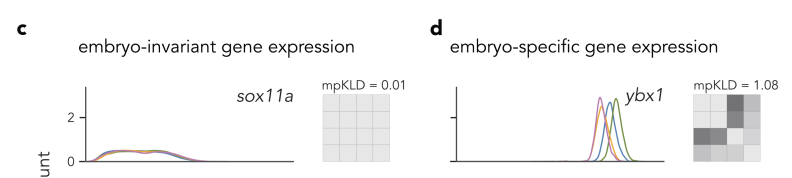

### Density plots for each embryo

In [144]:
#function: returns a dataframe with columns counts, and the cluster label (does it for each gene)
#inputs: adata object, cluster column, specific gene, type of counts (all are log)
#output: dataframe with a column of counts and the label (which fish)


def singlegenebycluster(adata, obs_column, gene, layer = 'scaled'):
    myclusters = adata.obs[obs_column].unique().sort_values()
    fulldata = pd.DataFrame(columns=['counts', 'cluster'])
    cluster_dfs = []
    for i in myclusters:
        adata_filter = adata[adata.obs[obs_column] == i].copy()
        myindex = adata_filter.var.index.get_loc(gene)
        
        if (layer == 'scaled'):
            mycounts = adata_filter.X[:, myindex].toarray()
            
        if (layer == 'log'):
            mycounts = adata_filter.raw.X[:, myindex].toarray()
            
        if (layer == 'counts'):
            mycounts1 = adata_filter.layers['counts'].toarray()
            mycounts = mycounts1[:, myindex]
 
        minidata = pd.DataFrame(mycounts, columns=['counts']).copy()
        minidata['cluster'] = i
        cluster_dfs.append(minidata)
    fulldata = pd.concat(cluster_dfs, ignore_index=True)
    
    return fulldata

In [145]:
#function: creates a dataframe for use in density plot, with counts, fish information and gene
#inputs: adata, column to separate (fish n), list of genes (str) and layer
#output: dataframe with counts, column info (fish) and gene

def countsbycluster(adata, obs_column, genes, layer = 'scaled'):
    bigframe = pd.DataFrame(columns = ['gene','counts', 'cluster'])
    gene_dfs = []
    for g in genes:
        geneframe = singlegenebycluster(adata, obs_column, g, layer)
        geneframe['gene'] = g
        gene_dfs.append(geneframe)
    bigframe = pd.concat(gene_dfs, ignore_index=True)
    return bigframe

In [174]:
#function: creates a density plot with RNA counts for a set of specific genes, for a particular cell type, separated by fish
#inputs: adata object, cell type, list of genes (str)
#output: graph comparing genes, different distributions colored by fish

def densityPlotCompareGenesbyFish(adata = [], cluster = 'Hindbrain', genes  = ['ndufb2', 'rps16'], large=6):
    
    myadata = adata[adata.obs['Cells_Annotations'] == cluster]
    comparetop = countsbycluster(myadata, 'fish', genes, 'scaled')
    
    f = plt.figure(figsize=(12,8))
    g = sns.FacetGrid(comparetop, hue = "cluster", row="gene",
                  height=3, aspect=4,)


    g.set(xlim=(-0.5, large))

    g.set_axis_labels("Log RNA Counts", "Fraction Cells")

    sns.set(font_scale=2, style='white')

    g.map(sns.kdeplot, "counts")
    g.add_legend()
    
    return g

In [147]:
#function: plots individual genes colored by fish
#input: adata for one timepoint, cell type/cluster as 'Cells_Annotations', list of genes, and max value of counts 'large'
#output: plot with multiple rows, each is one gene

def plotGenes(adata = [], cluster = 'Hindbrain', genes = [], large=6):
    
    
    myadata = adata.copy()
    
    if 'Cells_Annotations' in adata.obs.columns:
            None
    
    elif cluster == 'whole_embryo':
        adata.obs['Cells_Annotations'] = 'whole_embryo'
        
    else:
        adata.obs = adata.obs.rename(columns={"zebrafish_anatomy_ontology_class": "Cells_Annotations"})
     
        
    return densityPlotCompareGenesbyFish(myadata, cluster, genes, large)
    

## *Example code:*
* We handpick genes for a specific cell cluster, and input a subset adata (for a timepoint)
* Plot distribution of the gene counts

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems

<Figure size 1200x800 with 0 Axes>

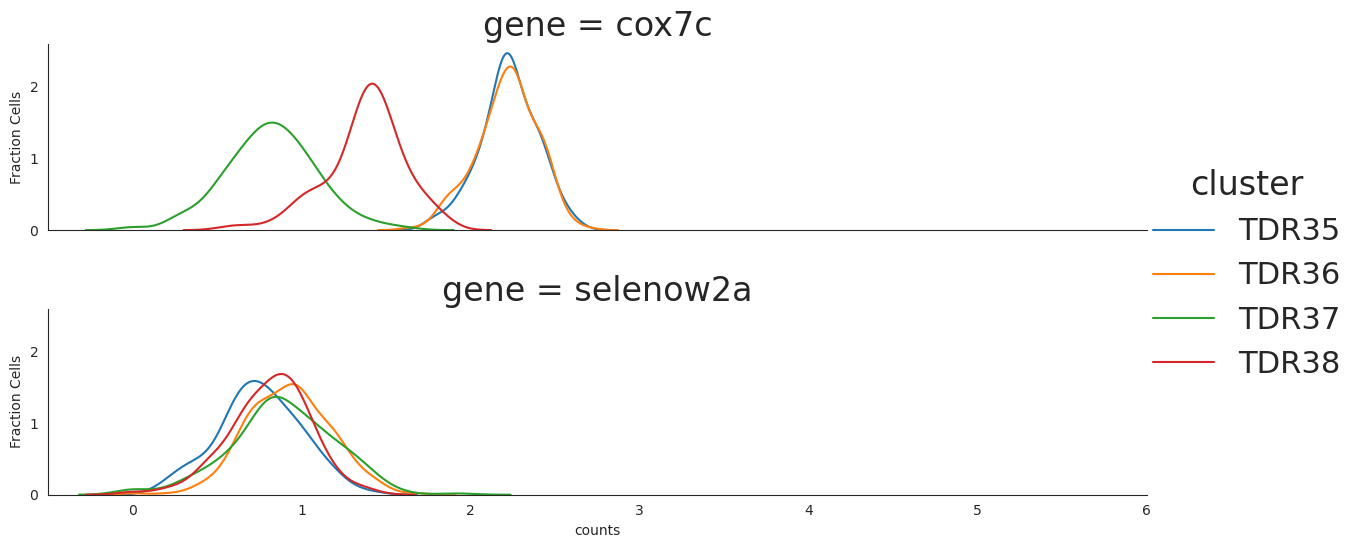

In [161]:
densityPlotCompareGenesbyFish(example_adata, 'neural_anterior', genes = ['cox7c', 'selenow2a'], large=6)

### Heatmap of pairwise Kullback-Leibler divergences between embryos

In [176]:
#function: makes a matrix with the pairwise KL values
#arguments: takes in a matrix of counts (sparse), a gene, cell type, list of fish (str), layer (log/scaled str), obs and var from adata as pd.DF
#output: a matrix with all pairwise KL scores for the fish

def kl_fish_matrix2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish = [], obs =pd.DataFrame, var=pd.DataFrame):

    fishcols = []
    
    for f1 in fish:
        f1row = []
        for f2 in fish:
            value = kl_fishpair_genecelltype2(matrix, gene, cluster, f1, f2, obs, var)
            
            if (value == -1):
                return -1
            f1row.append(value)
        fishcols.append(f1row)      

    return fishcols 

In [177]:
#function: helper to make the matrix, gets the specific arrays and sends to kl function
#arguments: matrix of counts (sparse), gene, cell type, two fish (str), layer (log/scaled str), obs and var from adata as pd.DF
#output: kl divergence score for two arrays (calls kl function)

def kl_fishpair_genecelltype2(matrix = [[],[]], gene = 'phtf2', cluster = 'Somite', fish1 = '44', fish2 = '46', obs=pd.DataFrame, var=pd.DataFrame):    
    
    row1 = obs['fish'].loc[lambda x: x==fish1].index.tolist()
    row2 = obs['fish'].loc[lambda x: x==fish2].index.tolist()
    
    myindex = int(var.index[var['index']==gene].tolist()[0])

    q = np.asarray(matrix.tocsr()[row1, myindex].todense()).flatten()
    p = np.asarray(matrix.tocsr()[row2, myindex].todense()).flatten()

    
    if (np.sum(p > 0) < 10) or (np.sum(q > 0) < 10):
        return -1
    else:
        return kl_divergence(q, p)

In [178]:
#function: calculation of KL for two numpy arrays
#arguments: two numpy arrays
#output: KL score (float)

def kl_divergence(fish1gene = [],  fish2gene = []):
    
    
    pkde = stats.gaussian_kde(np.array(fish1gene))
    qkde = stats.gaussian_kde(np.array(fish2gene))
    maxval = np.max([np.max(fish1gene), np.max(fish2gene)])
    minval = np.min([np.min(fish1gene), np.min(fish2gene)])
    
    offset = 1
    newx = np.linspace(minval-offset, maxval+offset,1000)
    
    p = pkde.pdf(newx)
    q = qkde.pdf(newx)
    
    newp = np.where(p< 1e-9, 1e-9, p)
    newq = np.where(q< 1e-9, 1e-9, q)

    
    kl_pair = stats.entropy(newp, newq)
    return kl_pair

In [179]:
#function: gets the matrix of pairwise KLD values
#input: adata for a single timepoint, cluster (cell type) as Cells Annotations, specific gene
#output: numpy matrix of KLD values

def make_kl_fishmatrix(adata, cluster, gene):
    
    mymatrix = adata.X.copy()
    
    if 'Cells_Annotations' in adata.obs.columns:
        None
    
    elif cluster == 'whole_embryo':
        adata.obs['Cells_Annotations'] = 'whole_embryo'
        
    else:
        adata.obs = adata.obs.rename(columns={"zebrafish_anatomy_ontology_class": "Cells_Annotations"})
     
    myobs = adata.obs.copy().reset_index()
    myvar = adata.var.copy().reset_index()
    mygene = gene
    mycluster = cluster
    myfish = adata.obs.fish.unique()
    
    
    
    my_matrix = kl_fish_matrix2(mymatrix, mygene, mycluster, myfish, myobs, myvar)
    
    return my_matrix
    

In [180]:
#function: creates a heatmap 
#input: adata for a single timepoint, cluster (Cells_Annotations), gene, minimum KLD value, max KLD value (set for heatmap)
#output: heatmap plot of pairwise KLD values

def make_kl_heatmap(adata, cluster, gene, mymin = 0, mymax = 20):
    
    mymatrix = make_kl_fishmatrix(adata, cluster, gene)
    
    greyscale = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
    
    sns.heatmap(mymatrix, vmin = mymin, vmax = mymax, cmap = greyscale)
    

Embryo palette colors, specify colors for each fish label

In [181]:
myfishpalette = {'TDR35': 'orchid', 'TDR36': 'orange', 'TDR37': 'olivedrab', 'TDR38': 'steelblue'}

### UMAP colored by fish

## *Example code:*
* We have already made a UMAP, which is attached to the adata
* Plot the adata, colored by fish

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:355: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


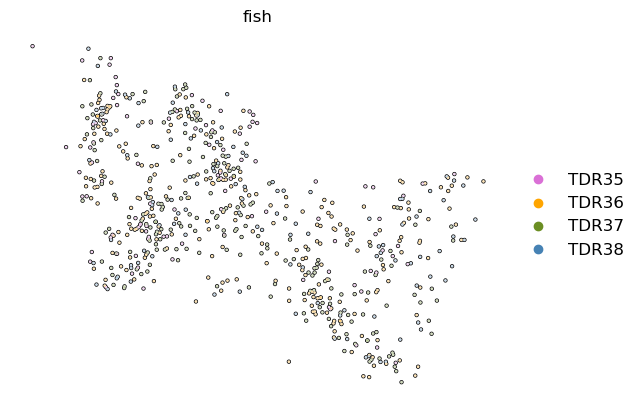

In [156]:
## input adata is a specific timepoint, with the umap already created


sc.pl.umap(example_adata, color="fish", add_outline=True, 
           legend_fontsize=12, legend_fontoutline=2,
           frameon=False, size=13, palette=myfishpalette, alpha=0.3,
          #save='umap_coloredbyfish_timepointspecific_12hpf_v.pdf'
          )

### Multiplot code, combine genes and heatmap

In [158]:
#function: multiplot of UMAP, histogram colored by fish next to heatmap of pairwise KLD scores between fish (for 2 genes)
#arguments: adata for single timepoint, adata with UMAP, two genes, cell type, min and max on histogram x-axis, title of plot
#output: figure with subplots

def makefigure(curradata= [[]], adataumap = [[]], gene1 = 'ptpn12', gene2 = 'lrp6', celltype = 'cell_type_1', distxmin=-0.1, distxmax=0.4):
    
    comparetop = countsbycluster(curradata, 'fish', [gene1, gene2], 'scaled')
    mymatrix_gene1 = make_kl_fishmatrix(curradata, celltype, gene1)
    mymatrix_gene2 = make_kl_fishmatrix(curradata, celltype, gene2)
    
    heatmax = np.max([np.max(mymatrix_gene1), np.max(mymatrix_gene2)]) + 0.02
    
    myfish = curradata.obs.fish.unique()
    
    
    myfishpalette = {myfish[0]: 'orchid', myfish[1]: 'orange', myfish[2]: 'olivedrab', myfish[3]: 'steelblue'}
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    subfigs = fig.subfigures(2,1, wspace=0)
    sns.set_style("white")
    

    greyscale = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)


    axestop = subfigs[0].subplots(1,4)
    axes1 = subfigs[1].subplots(1, 4)

    gs = axestop[0].get_gridspec() #Get gridspecs
    for i in range(4):

        axestop[i].remove()


    umap1 = subfigs[0].add_subplot(gs[0:1, 0:1])
    genecomp1 = subfigs[0].add_subplot(gs[0:1, 1:3])
    heatgene1 = subfigs[0].add_subplot(gs[0:1, 3:4])


    sc.pl.umap(curradata, color="fish", show=False, size=13, ax=umap1, palette=myfishpalette, legend_loc=None, alpha=0.3)

    sns.kdeplot(data=comparetop[comparetop.gene == gene1], x="counts", common_norm=False, legend=False, palette=myfishpalette, hue='cluster', ax=genecomp1).set(title=gene1)

    genecomp1.axis(xmin=distxmin,xmax=distxmax, ymin=0, ymax=3)

    sns.heatmap(mymatrix_gene1, vmin = 0, vmax = heatmax, cmap = greyscale, square=True, ax=heatgene1)

    gs2 = axes1[0].get_gridspec() #Get gridspecs
    for i in range(4):

        axes1[i].remove()


    umap2 = subfigs[1].add_subplot(gs2[0:1, 0:1])
    genecomp2 = subfigs[1].add_subplot(gs2[0:1, 1:3])
    heatgene2 = subfigs[1].add_subplot(gs2[0:1, 3:4])


    sns.kdeplot(data=comparetop[comparetop.gene == gene2], x="counts", hue='cluster', legend=False, palette=myfishpalette, common_norm=False, ax=genecomp2).set(title=gene2)
    genecomp2.axis(xmin=distxmin,xmax=distxmax, ymin=0, ymax=3)


    sns.heatmap(mymatrix_gene2, vmin = 0, vmax = heatmax, cmap = greyscale, square=True, ax=heatgene2)
    heatgene2.axis('off')
  
    

## *Example code:*
* We hand-pick two genes to plot as distributions and their corresponding Kullback-Leibler divergence pairwise heatmaps
* The first adata is the adata object for the distributions, and the second is for the UMAP (if the adata for the UMAP is different)

/home/sarah.ancheta/miniconda3/envs/py38zebra/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


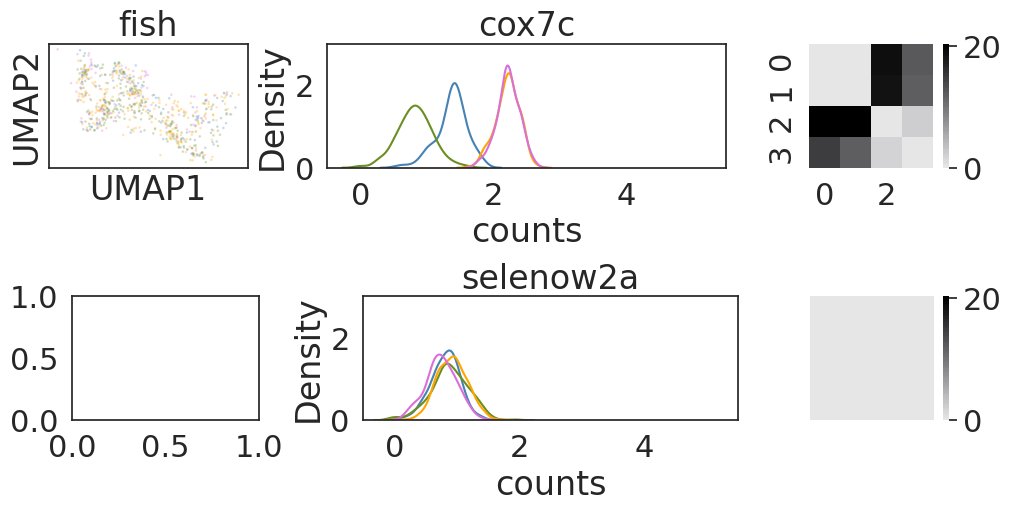

In [182]:
makefigure(example_adata, example_adata, 'cox7c', 'selenow2a', 'neural_anterior', -0.5, 5.5)

## 3.2 Kolmogorov-Smirnov test between adjacent timepoints

### We compare the differences between the mpKLD distributions of different timepoints using the Kolmogorov-Smirnov test:
* We upload the **mpKLD dataframe for a single cell cluster (or whole embryo) and multiple timepoints,** as the timepointHPF column
* Then input the two adjacent timepoints that we want to compare, and the mpKLD values that make up the distribution (the column 'kl_median') 
* We want to get the p-value of the * between the distributions
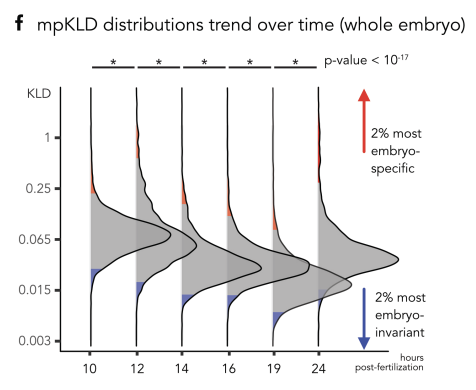

In [183]:
#function: calculates the Kolmogorov-Smirnov test for two timepoints
#arguments: mpKLD dataframe, two timepoints to compare, and the desired cell cluster
#output: the KS test statistic and p-value

def adjacent_time_KStest(df = pd.DataFrame, time1 = 12, time2 = 14, mycluster = 'neural_anterior'):
    
    df_time1 = df[(df.timepointHPF == time1) & (df.cluster == mycluster)].copy()
    df_time2 = df[(df.timepointHPF == time2) & (df.cluster == mycluster)].copy()

    return stats.ks_2samp(df_time1['kl_median'], df_time2['kl_median'])

## *Example code:*
* We upload the dataset with multiple timepoints which has already been filtered and has columns 'timepointHPF' and 'kl_median'
* To 'adjacent_time_KStest' we choose adjacent timepoints 12 and 14 from column 'timepointHPF' and choose the cell cluster 'neural_posterior'

In [164]:
df_timepoints = pd.read_csv('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/kldf_earlytimepts_newannot_Nov22.csv')

In [165]:
df_timepoints

,Unnamed: 0,gene,cluster,kl_amax,kl_amin,kl_median,std,kl_mean,timepointHPF,kl_log2,fraction_0s,gene_mean,gene_std
0,4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12,-4.064441,0.432314,0.182933,0.211550
1,5,si:ch211-51e12.7,neural_anterior,1.193341,0.059143,0.327692,0.325697,0.373929,12,-1.419163,0.000000,1.797247,0.232920
2,6,mrps10,neural_anterior,0.558241,0.013300,0.214830,0.154363,0.209599,12,-2.254296,0.033479,0.649810,0.265949
3,10,rpl18a,neural_anterior,1.117136,0.086507,0.300171,0.391875,0.469353,12,-1.091256,0.000000,3.303375,0.181310
4,11,xpot,neural_anterior,0.133148,0.022756,0.049089,0.038282,0.058212,12,-4.102530,0.377001,0.196325,0.189667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106195,272710,mt-nd4l,whole_embryo,0.132436,0.015440,0.043247,0.037584,0.054737,24,-4.531262,0.287595,0.364109,0.311276
106196,272711,mt-nd4,whole_embryo,0.100463,0.014155,0.063277,0.025582,0.059226,24,-3.982166,0.000852,1.805176,0.407225
106197,272715,mt-nd5,whole_embryo,0.317533,0.003889,0.078970,0.094685,0.102003,24,-3.662555,0.007511,1.313451,0.419231
106198,272716,mt-nd6,whole_embryo,0.081729,0.014885,0.027538,0.019830,0.036268,24,-5.182413,0.357674,0.290961,0.277779


In [172]:
adjacent_time_KStest(df_timepoints, 12, 14, 'neural_posterior')

KstestResult(statistic=0.27532181185809196, pvalue=4.748325709932233e-198)

## 3.3 Using null model dataframe to make supplementary plots, comparing the true mpKLD with the randomized embryo mpKLD

### We take the dataframe from the randomized null model of embryos, and create a multiplot comparison with the true mpKLd scores (multiplot found in Supp. 8):
* For each gene, we calculate the z-score from the randomized distribution of scores, and and the true mpKLD score
* We plot a multiplot for a specific timepoint and cell cluster:
    * Two mpKLD distributions (for the null and the original data)
    * Scatterplot to see the correlation between the mpKLD score (y-axis) and the z-score for each gene
    * The distribution of z-scores for the cell cluster

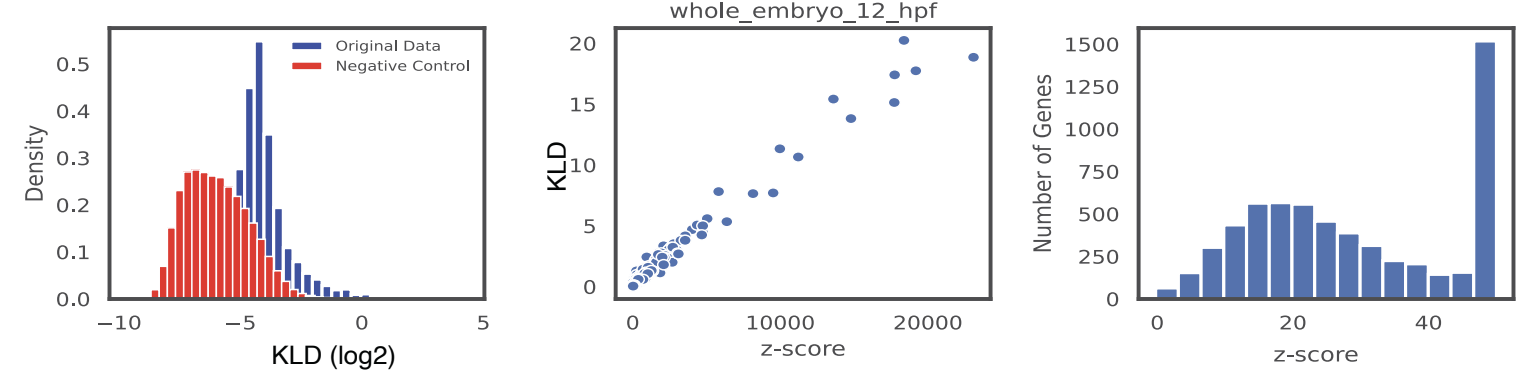

In [194]:
#function: calculates the Kolmogorov-Smirnov test for two timepoints
#arguments: mpKLD dataframe, two timepoints to compare, and the desired cell cluster
#output: the KS test statistic and p-value

def add_kl_log2(df = pd.DataFrame):
    
    if 'kl_log2' in df.columns:
        
        return df
    else:
        df['kl_log2'] = np.log2(df['median'].copy())
        
        return df

In [195]:
#function: returns dataframe with z-scores, calculated for each gene. z-scores are capped are the max threshold
#input: scrambled/null KLD dataframe, original KLD dataframe, (both for one timepoint) z-score threshold (to cap)
#output: z-score dataframe

def get_zscore_scrambleDF(nulldf = pd.DataFrame, original = pd.DataFrame, threshold = 10):
    
    df1 = nulldf.groupby(['gene'])['median'].agg('mean').to_frame().rename(columns={'median':'scramble_mean'})
    df2 = nulldf.groupby(['gene'])['median'].agg('std').to_frame().rename(columns={'median': 'scramble_sd'})
    df3 = original[['gene', 'kl_median']].set_index('gene')
    
    combodf = pd.concat([df1, df2, df3], axis = 1, join = 'inner')
    combodf['z-score'] = ((combodf['kl_median'] - combodf['scramble_mean'])/combodf['scramble_sd'])
    
    combodf['over10_zscore'] = combodf['z-score'].copy()
    combodf['over10_zscore'].where(combodf['over10_zscore'] <= threshold, threshold, inplace=True)
    
    return combodf
    

In [196]:
#function: multiplot with the original/null histograms, z-score vs KLD score, bar plot of z-score values (# of genes)
#input: original KLD dataframe, null/scramble KLD dataframe for one celltype/timepoint, cell type, timepoint, max z-score, plot title 
#output: multiplot

def allscramble_nullplots(bigDF = pd.DataFrame, scrambleDF = pd.DataFrame, cluster='PSM', timepoint=12, threshold=10, mytitle='mytitle'):   
    
    fig = plt.figure(figsize=(10, 3), constrained_layout=True)
    subfigs = fig.subfigures(1,1, wspace=0)


    axestop = subfigs.subplots(1,3)

    gs = axestop[0].get_gridspec() #Get gridspecs
    for i in range(3):

        axestop[i].remove()


    null_originaldist = subfigs.add_subplot(gs[0:1, 0:1])
    zscorescatter = subfigs.add_subplot(gs[0:1, 1:2])
    zscoredist = subfigs.add_subplot(gs[0:1, 2:3])



    miniDF = bigDF[(bigDF.cluster == cluster) & (bigDF.timepointHPF == timepoint)].copy()
    myzs = get_zscore_scrambleDF(scrambleDF, miniDF, threshold)
    zscoredist.hist(myzs['over10_zscore'], 15)
    zscoredist.set_xlabel('z-score, set values above to ' + str(threshold))
    zscoredist.set_ylabel('Number of Genes')



    null_originaldist.hist(miniDF['kl_log2'], 30, density=True, alpha =0.5, color='blue', label='Original Data')
    null_originaldist.hist(scrambleDF['kl_log2'], 30, density=True, alpha=0.5, color='red', label='Negative Control')
    null_originaldist.legend(loc=1, prop={'size': 8})
    null_originaldist.set_xlabel('Inter-fish Diveristy (KL log2)')
    null_originaldist.set_ylabel('Density')

    
    mytitle = cluster+'_'+str(timepoint)+'_hpf'

    sns.scatterplot(data=myzs, x='z-score', y='kl_median', ax=zscorescatter).set(title=mytitle) 

## *Example code:*
* Use the df_timepoints dataframe from above
* We add the 'kl_log2' column with the function 'add_kl_log2' as some pre-processing for the plot
* Upload the desired null model dataframe, this one is for 12hpf PSM cell cluster and add the 'kl_log2' column
* We call the multiplot function 'allscramble_nullplots' with the two dataframes, specify the cell cluster, timepoint, the upperbound on the z-score for the histogram and the title


In [189]:
original_df = add_kl_log2(df_timepoints)
original_df.head()

,Unnamed: 0,gene,cluster,kl_amax,kl_amin,kl_median,std,kl_mean,timepointHPF,kl_log2,fraction_0s,gene_mean,gene_std
0,4,msgn1,neural_anterior,0.131384,0.023262,0.049207,0.034179,0.059770,12,-4.064441,0.432314,0.182933,0.211550
1,5,si:ch211-51e12.7,neural_anterior,1.193341,0.059143,0.327692,0.325697,0.373929,12,-1.419163,0.000000,1.797247,0.232920
2,6,mrps10,neural_anterior,0.558241,0.013300,0.214830,0.154363,0.209599,12,-2.254296,0.033479,0.649810,0.265949
3,10,rpl18a,neural_anterior,1.117136,0.086507,0.300171,0.391875,0.469353,12,-1.091256,0.000000,3.303375,0.181310
4,11,xpot,neural_anterior,0.133148,0.022756,0.049089,0.038282,0.058212,12,-4.102530,0.377001,0.196325,0.189667


In [191]:
psm_scramble = pd.read_csv('/mnt/ibm_lg/sarah.ancheta/ZF_atlas/intra_inter_v4/psm_12hpf_Dec2null_scramble.csv')

In [192]:
null_df = add_kl_log2(psm_scramble)
null_df.head()

,Unnamed: 0,gene,cluster,amax,amin,median,std,mean,Random_State,kl_log2
0,0,phtf2-1,PSM,0.415692,0.011835,0.074170,0.135671,0.135055,mixed_fish0,-3.753023
1,1,dusp16,PSM,0.128387,0.013489,0.057622,0.037141,0.060846,mixed_fish0,-4.117242
2,2,crebl2,PSM,0.116196,0.007198,0.055119,0.032384,0.057762,mixed_fish0,-4.181306
3,3,msgn1,PSM,0.012131,0.001306,0.009817,0.003441,0.008764,mixed_fish0,-6.670458
4,4,si:ch211-51e12.7,PSM,0.058651,0.014788,0.023274,0.015288,0.031029,mixed_fish0,-5.425144


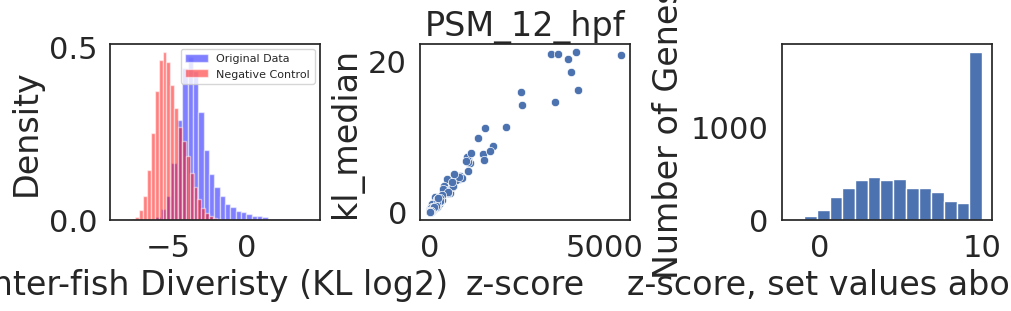

In [197]:
allscramble_nullplots(original_df, null_df, 'PSM', 12, 10, 'psm_12hpf')